In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
spark = SparkSession.builder \
    .appName("AnalisisBarcoCrucero") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/18 09:16:57 WARN Utils: Your hostname, ArchJapo, resolves to a loopback address: 127.0.1.1; using 10.0.0.36 instead (on interface wlp0s20f3)
25/10/18 09:16:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/18 09:16:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("barcos_crucero.csv", header=True, inferSchema=True)

df.printSchema()
print(f"Total de filas: {df.count()}")
print(f"Total de columnas: {len(df.columns)}")

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)

Total de filas: 158
Total de columnas: 9


In [5]:
df.show(10)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [6]:
df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [7]:
print("Conteo de valores nulos por columna:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Conteo de valores nulos por columna:
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [8]:
print("Filas duplicadas:")
duplicates = df.count() - df.dropDuplicates().count()
print(f"Número de filas duplicadas: {duplicates}")

Filas duplicadas:
Número de filas duplicadas: 0


In [9]:
df_clean = df.dropna()

In [10]:
df_clean = df_clean.dropDuplicates()

In [11]:
df_clean = df_clean.withColumn("Ship_name", trim(col("Ship_name")))
df_clean = df_clean.withColumn("Cruise_line", trim(col("Cruise_line")))

In [12]:
numeric_cols = ["Age", "Tonnage", "passengers", "length", "cabins", "passenger_density", "crew"]

for col_name in numeric_cols:
    df_clean = df_clean.filter(col(col_name) > 0)

In [13]:
print(f"Filas después de limpieza: {df_clean.count()}")
print(f"Filas removidas: {df.count() - df_clean.count()}")

Filas después de limpieza: 158
Filas removidas: 0


In [14]:
print("Distribución de líneas de crucero:")
df_clean.groupBy("Cruise_line").count().orderBy(col("count").desc()).show()

Distribución de líneas de crucero:
+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+



In [15]:
print("Estadísticas de edad por línea de crucero:")
df_clean.groupBy("Cruise_line").agg(
    avg("Age").alias("edad_promedio"),
    min("Age").alias("edad_minima"),
    max("Age").alias("edad_maxima")
).orderBy(col("edad_promedio").desc()).show()

Estadísticas de edad por línea de crucero:
+-----------------+------------------+-----------+-----------+
|      Cruise_line|     edad_promedio|edad_minima|edad_maxima|
+-----------------+------------------+-----------+-----------+
|           Orient|              48.0|         48|         48|
|         Windstar|              25.0|         23|         27|
|         Seabourn|              24.0|         21|         27|
|           Cunard|              20.0|          6|         44|
|             Star|19.166666666666668|         12|         24|
|        Norwegian| 17.46153846153846|          6|         40|
| Holland_American|17.071428571428573|          5|         29|
|            Costa|16.181818181818183|          6|         27|
|Regent_Seven_Seas|              15.8|         10|         27|
|        Silversea|             15.75|         12|         19|
|         Carnival|15.227272727272727|          6|         28|
|              MSC|            15.125|          5|         36|
|           

In [16]:
print("Estadísticas de tonelaje por línea de crucero:")
df_clean.groupBy("Cruise_line").agg(
    avg("Tonnage").alias("tonelaje_promedio"),
    min("Tonnage").alias("tonelaje_minimo"),
    max("Tonnage").alias("tonelaje_maximo")
).orderBy(col("tonelaje_promedio").desc()).show()

Estadísticas de tonelaje por línea de crucero:
+-----------------+------------------+------------------+------------------+
|      Cruise_line| tonelaje_promedio|   tonelaje_minimo|   tonelaje_maximo|
+-----------------+------------------+------------------+------------------+
|  Royal_Caribbean|107.01099999999998|            48.563|             220.0|
|           Cunard|103.90899999999999|            70.327|             151.4|
|         Princess|            87.538|30.276999999999997|             116.0|
|         Carnival| 84.65272727272726|            46.052|110.23899999999999|
|           Disney|            83.169|              83.0|            83.338|
|              P&O| 77.85883333333334|              45.0|             115.0|
|        Celebrity|           76.1586|             2.329|             122.0|
|            Costa| 71.09654545454545|              25.0|             112.0|
|              MSC|          63.77225|            16.852|             133.5|
|        Norwegian| 63.716615

In [17]:
print("Estadísticas de capacidad de pasajeros:")
df_clean.groupBy("Cruise_line").agg(
    avg("passengers").alias("pasajeros_promedio"),
    sum("passengers").alias("capacidad_total")
).orderBy(col("capacidad_total").desc()).show()

Estadísticas de capacidad de pasajeros:
+-----------------+------------------+------------------+
|      Cruise_line|pasajeros_promedio|   capacidad_total|
+-----------------+------------------+------------------+
|  Royal_Caribbean| 28.84956521739131| 663.5400000000001|
|         Carnival|23.458181818181814| 516.0799999999999|
|         Princess|21.618823529411763|            367.52|
|        Norwegian|17.876923076923074|232.39999999999998|
|            Costa|              19.2|             211.2|
| Holland_American|14.213571428571429|            198.99|
|        Celebrity|17.979999999999997|179.79999999999998|
|              MSC|          18.87875|            151.03|
|              P&O|20.819999999999997|124.91999999999999|
|           Cunard|             21.37|             64.11|
|             Star| 9.431666666666665| 56.58999999999999|
|           Disney|              17.5|              35.0|
|Regent_Seven_Seas|             5.208|             26.04|
|          Oceania|             

In [18]:
df_clean = df_clean.withColumn(
    "ratio_pasajeros_tripulacion",
    round(col("passengers") / col("crew"), 2)
)

In [19]:
df_clean = df_clean.withColumn(
    "categoria_edad",
    when(col("Age") < 10, "Nuevo")
    .when((col("Age") >= 10) & (col("Age") < 20), "Medio")
    .otherwise("Antiguo")
)

In [20]:
df_clean = df_clean.withColumn(
    "categoria_tamaño",
    when(col("Tonnage") < 50, "Pequeño")
    .when((col("Tonnage") >= 50) & (col("Tonnage") < 100), "Mediano")
    .otherwise("Grande")
)

In [21]:
print("Barcos por categoría de edad:")
df_clean.groupBy("categoria_edad").count().orderBy("categoria_edad").show()

Barcos por categoría de edad:
+--------------+-----+
|categoria_edad|count|
+--------------+-----+
|       Antiguo|   44|
|         Medio|   84|
|         Nuevo|   30|
+--------------+-----+



In [22]:
print("Barcos por categoría de tamaño:")
df_clean.groupBy("categoria_tamaño").count().orderBy("categoria_tamaño").show()

Barcos por categoría de tamaño:


+----------------+-----+
|categoria_tamaño|count|
+----------------+-----+
|          Grande|   32|
|         Mediano|   82|
|         Pequeño|   44|
+----------------+-----+



In [23]:
print("Top 10 barcos por capacidad de pasajeros:")
df_clean.select("Ship_name", "Cruise_line", "passengers", "crew", "ratio_pasajeros_tripulacion") \
    .orderBy(col("passengers").desc()) \
    .show(10, truncate=False)

Top 10 barcos por capacidad de pasajeros:
+------------+---------------+----------+-----+---------------------------+
|Ship_name   |Cruise_line    |passengers|crew |ratio_pasajeros_tripulacion|
+------------+---------------+----------+-----+---------------------------+
|Oasis       |Royal_Caribbean|54.0      |21.0 |2.57                       |
|Liberty     |Royal_Caribbean|43.7      |13.6 |3.21                       |
|Freedom     |Royal_Caribbean|43.7      |13.6 |3.21                       |
|Fantasia    |MSC            |39.59     |13.13|3.02                       |
|Serena      |Costa          |38.0      |10.9 |3.49                       |
|Emerald     |Princess       |37.82     |12.0 |3.15                       |
|Freedom     |Carnival       |37.0      |11.5 |3.22                       |
|Independence|Royal_Caribbean|36.34     |13.6 |2.67                       |
|Ventura     |P&O            |35.74     |12.2 |2.93                       |
|Explorer    |Royal_Caribbean|31.14     |11.76

In [24]:
print("Ratio pasajeros-tripulación por línea de crucero:")
df_clean.groupBy("Cruise_line").agg(
    avg("ratio_pasajeros_tripulacion").alias("ratio_promedio_pasajeros_tripulacion")
).orderBy(col("ratio_promedio_pasajeros_tripulacion").desc()).show()

Ratio pasajeros-tripulación por línea de crucero:
+-----------------+------------------------------------+
|      Cruise_line|ratio_promedio_pasajeros_tripulacion|
+-----------------+------------------------------------+
|  Royal_Caribbean|                  2.9165217391304354|
|              MSC|                  2.4974999999999996|
|            Costa|                  2.4045454545454543|
|              P&O|                  2.3783333333333334|
|           Orient|                                2.36|
|         Carnival|                  2.3272727272727276|
|        Norwegian|                  2.3261538461538462|
| Holland_American|                  2.2742857142857145|
|         Princess|                                2.27|
|        Celebrity|                  2.2190000000000003|
|           Cunard|                  2.0833333333333335|
|          Azamara|                                1.95|
|           Disney|                                1.85|
|         Windstar|                  1

Matriz de Correlación:
--------------------------------------------------------------------------------
Variable            Age            Tonnage        passengers     length         cabins         passenger_densitycrew           
--------------------------------------------------------------------------------------------------------------------------------------------
Age                 1.0000         -0.6066        -0.5155        -0.5323        -0.5100        -0.2788        -0.5307        
Tonnage             -0.6066        1.0000         0.9451         0.9224         0.9488         -0.0408        0.9276         
passengers          -0.5155        0.9451         1.0000         0.8835         0.9763         -0.2949        0.9152         
length              -0.5323        0.9224         0.8835         1.0000         0.8898         -0.0905        0.8959         
cabins              -0.5100        0.9488         0.9763         0.8898         1.0000         -0.2532        0.9508       

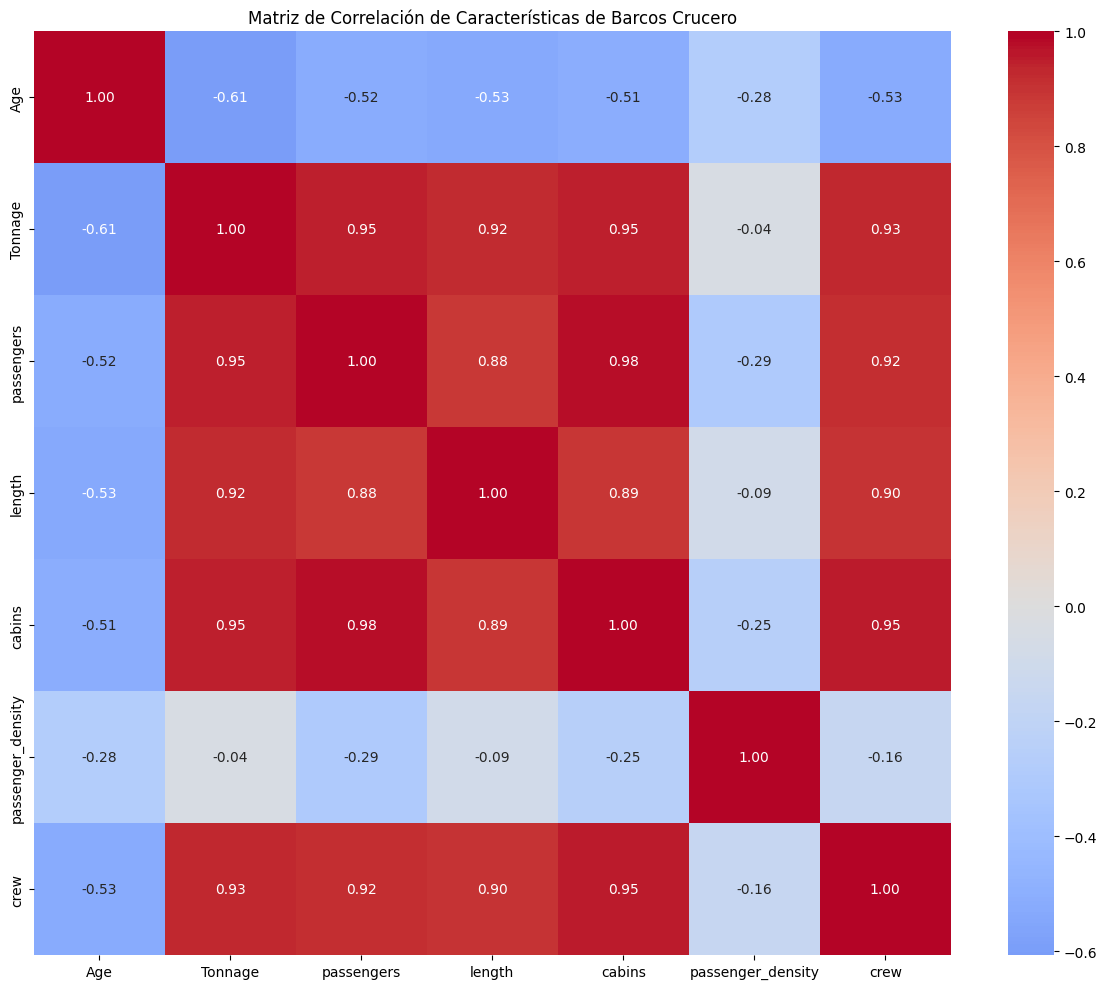

In [25]:
correlation_cols = ["Age", "Tonnage", "passengers", "length", "cabins", "passenger_density", "crew"]

print("Matriz de Correlación:")
print("-" * 80)

correlation_matrix = {}

for col1 in correlation_cols:
    correlation_matrix[col1] = {}
    for col2 in correlation_cols:
        if col1 == col2:
            correlation_matrix[col1][col2] = 1.0
        else:
            corr = df_clean.stat.corr(col1, col2)
            correlation_matrix[col1][col2] = corr

print(f"{'Variable':<20}", end="")
for col in correlation_cols:
    print(f"{col:<15}", end="")
print()
print("-" * 140)

for col1 in correlation_cols:
    print(f"{col1:<20}", end="")
    for col2 in correlation_cols:
        print(f"{correlation_matrix[col1][col2]:<15.4f}", end="")
    print()

import numpy as np
corr_array = np.array([[correlation_matrix[col1][col2] for col2 in correlation_cols] 
                       for col1 in correlation_cols])

plt.figure(figsize=(12, 10))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            xticklabels=correlation_cols, yticklabels=correlation_cols)
plt.title("Matriz de Correlación de Características de Barcos Crucero")
plt.tight_layout()
plt.show()

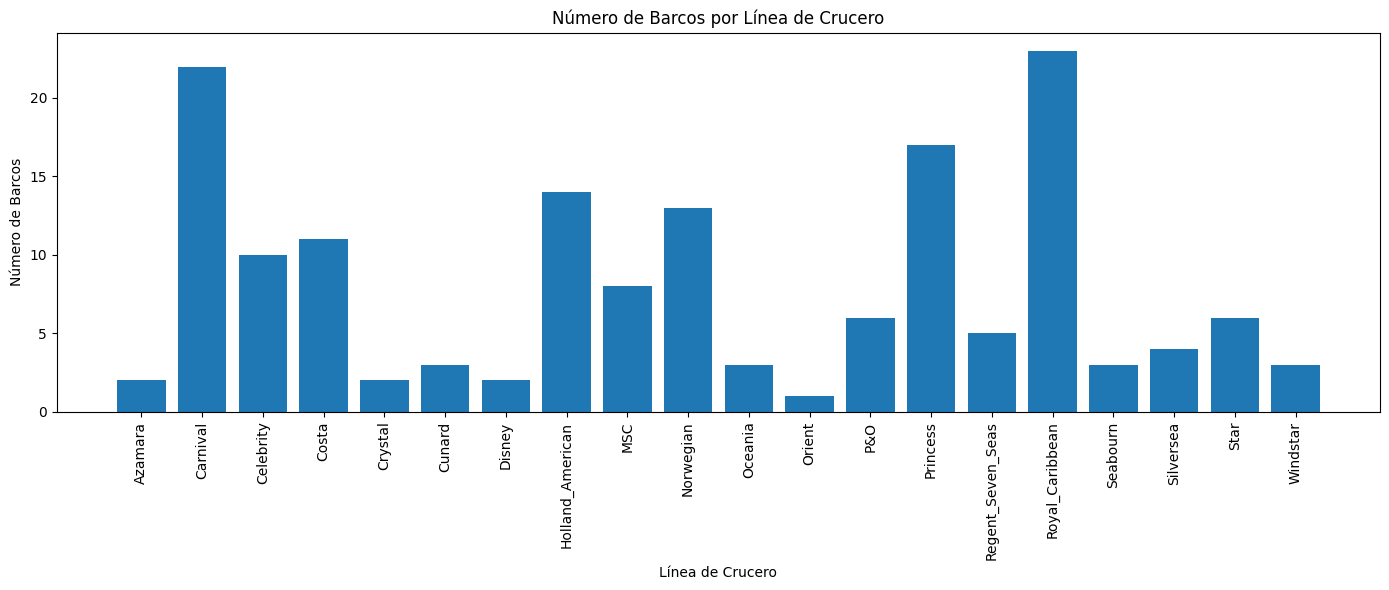

In [26]:
cruise_line_counts_spark = df_clean.groupBy("Cruise_line").count().orderBy("Cruise_line")
cruise_line_data = cruise_line_counts_spark.collect()

cruise_lines = [row["Cruise_line"] for row in cruise_line_data]
counts = [row["count"] for row in cruise_line_data]

plt.figure(figsize=(14, 6))
plt.bar(cruise_lines, counts)
plt.xlabel("Línea de Crucero")
plt.ylabel("Número de Barcos")
plt.title("Número de Barcos por Línea de Crucero")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

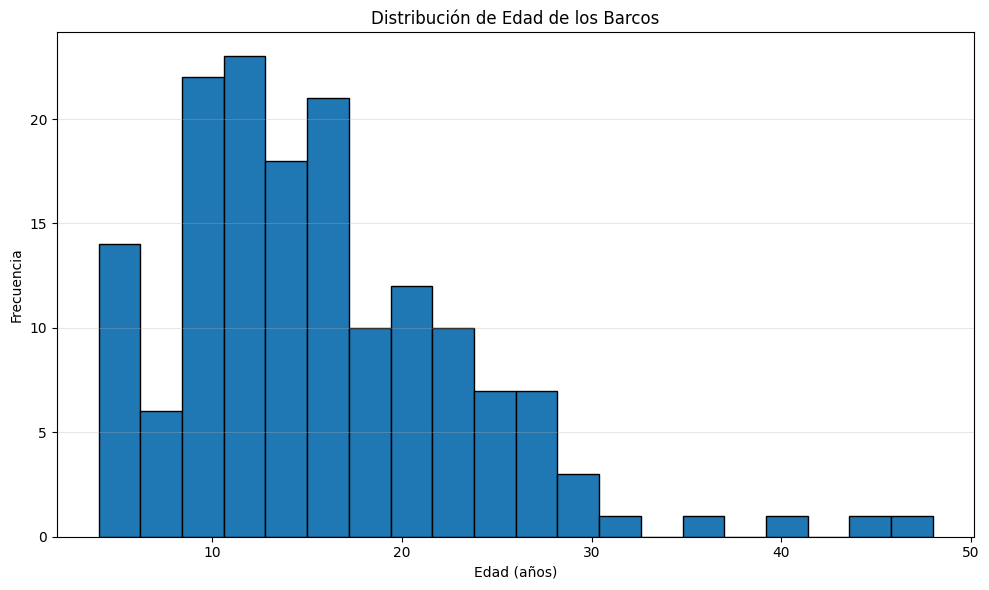

In [27]:
age_data_spark = df_clean.select("Age").collect()
ages = [row["Age"] for row in age_data_spark]

plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, edgecolor="black")
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Edad de los Barcos")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

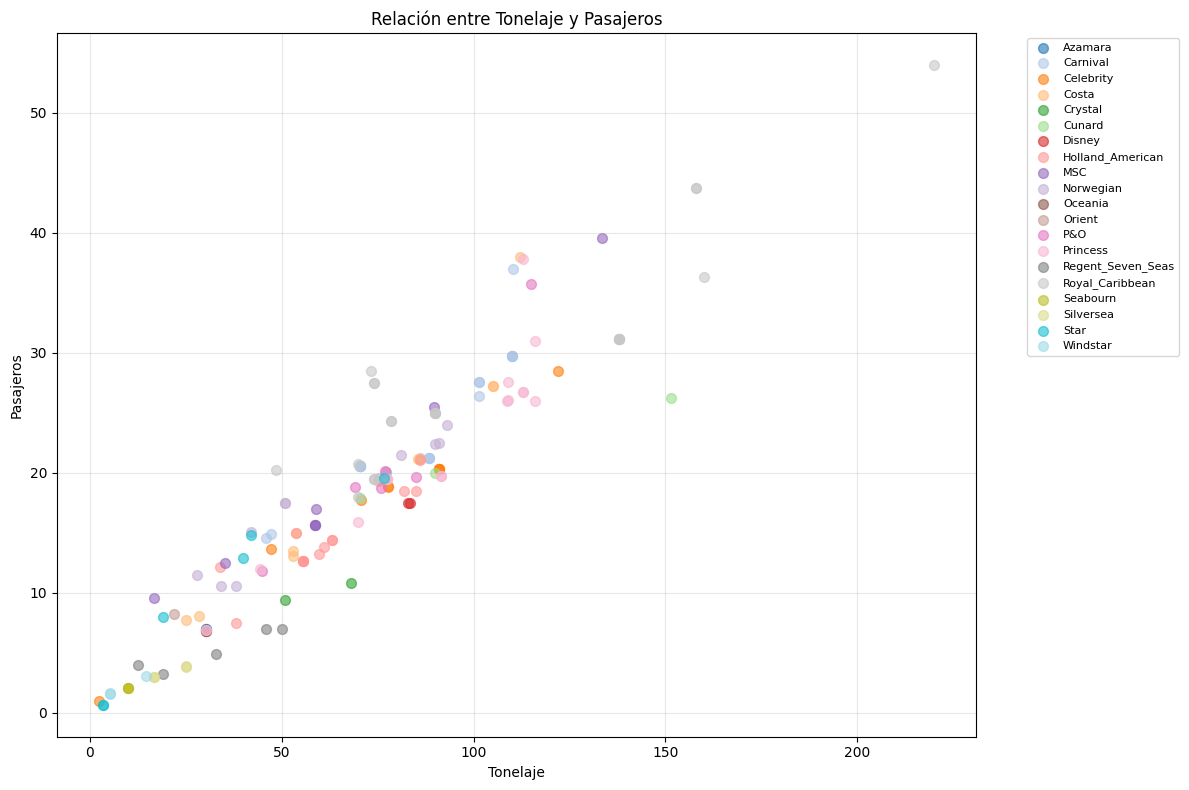

In [28]:
scatter_data_spark = df_clean.select("Tonnage", "passengers", "Cruise_line").collect()

cruise_lines_list = df_clean.select("Cruise_line").distinct().rdd.map(lambda r: r[0]).collect()
colors = plt.cm.tab20(np.linspace(0, 1, len(cruise_lines_list)))

plt.figure(figsize=(12, 8))

cruise_line_dict = {}
for row in scatter_data_spark:
    cruise_line = row["Cruise_line"]
    if cruise_line not in cruise_line_dict:
        cruise_line_dict[cruise_line] = {"Tonnage": [], "passengers": []}
    cruise_line_dict[cruise_line]["Tonnage"].append(row["Tonnage"])
    cruise_line_dict[cruise_line]["passengers"].append(row["passengers"])

for i, cruise_line in enumerate(sorted(cruise_line_dict.keys())):
    data = cruise_line_dict[cruise_line]
    plt.scatter(data["Tonnage"], data["passengers"], 
                label=cruise_line, alpha=0.6, s=50, color=colors[i])

plt.xlabel("Tonelaje")
plt.ylabel("Pasajeros")
plt.title("Relación entre Tonelaje y Pasajeros")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6332/3241990513.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=cruise_lines_sorted)


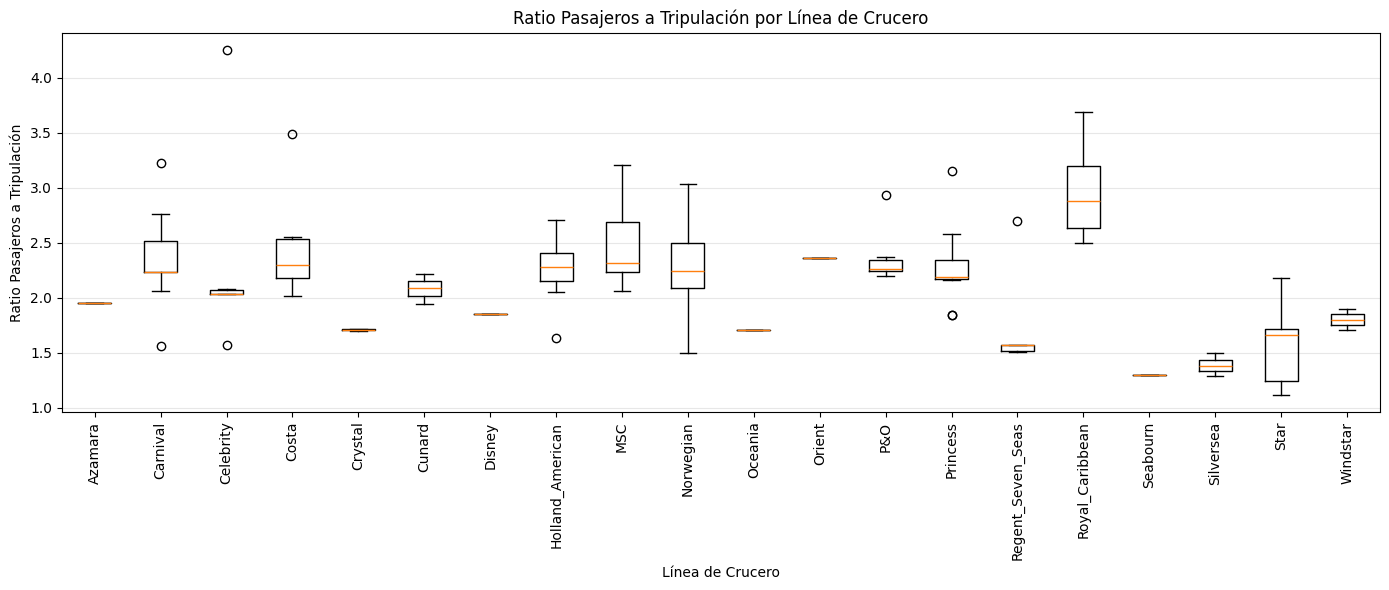

In [29]:
ratio_data_spark = df_clean.select("Cruise_line", "ratio_pasajeros_tripulacion").collect()

cruise_line_ratios = {}
for row in ratio_data_spark:
    cruise_line = row["Cruise_line"]
    if cruise_line not in cruise_line_ratios:
        cruise_line_ratios[cruise_line] = []
    cruise_line_ratios[cruise_line].append(row["ratio_pasajeros_tripulacion"])

plt.figure(figsize=(14, 6))
cruise_lines_sorted = sorted(cruise_line_ratios.keys())
data_for_boxplot = [cruise_line_ratios[cl] for cl in cruise_lines_sorted]

plt.boxplot(data_for_boxplot, labels=cruise_lines_sorted)
plt.xlabel("Línea de Crucero")
plt.ylabel("Ratio Pasajeros a Tripulación")
plt.title("Ratio Pasajeros a Tripulación por Línea de Crucero")
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

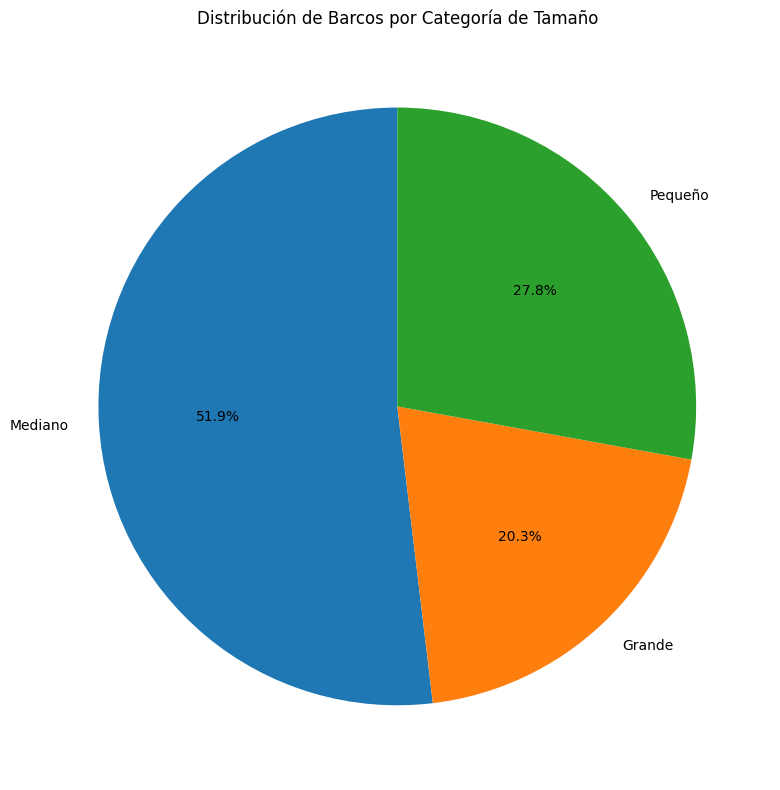

In [30]:
size_data_spark = df_clean.groupBy("categoria_tamaño").count().collect()

categories = [row["categoria_tamaño"] for row in size_data_spark]
counts = [row["count"] for row in size_data_spark]

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=categories, autopct="%1.1f%%", startangle=90)
plt.title("Distribución de Barcos por Categoría de Tamaño")
plt.tight_layout()
plt.show()

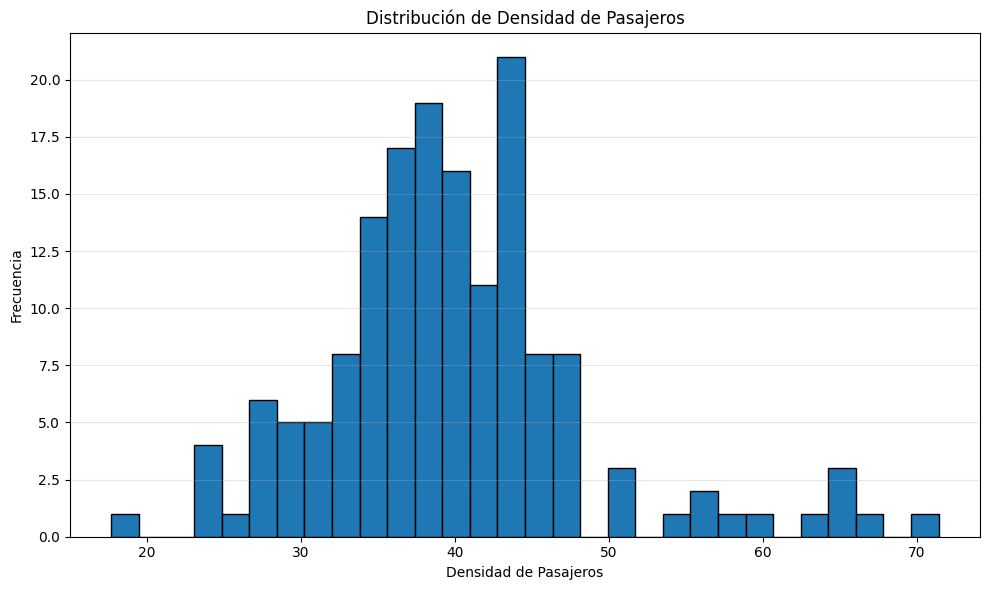

In [31]:
density_data_spark = df_clean.select("passenger_density").collect()
densities = [row["passenger_density"] for row in density_data_spark]

plt.figure(figsize=(10, 6))
plt.hist(densities, bins=30, edgecolor="black")
plt.xlabel("Densidad de Pasajeros")
plt.ylabel("Frecuencia")
plt.title("Distribución de Densidad de Pasajeros")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
df_clean.write.csv("barcos_crucero_clean.csv", header=True, mode="overwrite")

In [33]:
df_clean.write.parquet("barcos_crucero_clean.parquet", mode="overwrite")

In [34]:
spark.stop()